In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re    # 正则用到

# 1.数据导入

In [3]:
#1、数据导入
# pd.set_option('display.max_columns', None)  # 显示所有列。这个加不加好像都可以。
titanic = pd.read_csv('titanic_train.csv')  # 使用pandas读取CSV文件
print(titanic.describe())        # titanic.describe()是用pandas计算count、mean等，注意有括号。

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


# 2.数据清洗

In [4]:
# 有部分数据记录的Age字段缺失，这里用中间值给它补全。fillna是pandas的缺失值补全函数。
titanic['Age'] = titanic['Age'].fillna(titanic['Age'].median())
print(titanic.describe())

# 性别有男女，但字符无法进行矩阵运算，所以将male替换为0，female替换为1。
print(titanic['Sex'].unique())  # 查看Sex字段共有几种分类['male' 'female']
titanic.loc[titanic['Sex'] == 'male', 'Sex'] = 0
titanic.loc[titanic['Sex'] == 'female', 'Sex'] = 1

# 同样上船地点有S、C、Q。不过这里缺失值用众数替换，因为谁多那么缺失值是该的可能性就越大。
print(titanic['Embarked'].value_counts())
titanic['Embarked'] = titanic['Embarked'].fillna('S')
titanic.loc[titanic['Embarked'] == 'S', 'Embarked'] = 0
titanic.loc[titanic['Embarked'] == 'C', 'Embarked'] = 1
titanic.loc[titanic['Embarked'] == 'Q', 'Embarked'] = 2

print(titanic) # 打印清洗过后的数据集

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.361582    0.523008   
std     257.353842    0.486592    0.836071   13.019697    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   22.000000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   35.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  
['male' 'female']
S    644
C    168
Q     77
Name: Embarked, dtype: int64
     Pa

# 3.线性回归、逻辑回归来预测（可以直接忽略？）

In [15]:
from sklearn.linear_model import LinearRegression #线性回归
from sklearn.model_selection import KFold #交叉验证用。因为test测试集很宝贵，所以在训练集分几等份来互相做交叉验证。

predictors = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']  # 指定一些特征。
alg = LinearRegression()    # sklearn的线性回归模型
kf = KFold(n_splits=3, random_state=1).split(titanic) # 将titanic数据集分成3份做交叉验证？？
predictions = []
for train, test in kf:
    train_predictors = titanic[predictors].iloc[train, :]
    # print(train_predictors)
    train_target = titanic['Survived'].iloc[train]
    # print(train_target)
    alg.fit(train_predictors, train_target)
    test_predictions = alg.predict(titanic[predictors].iloc[test, :])
    # print(titanic[predictors].iloc[test, :])
    predictions.append(test_predictions)
predictions = np.concatenate(predictions, axis=0)
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0
accuracy = len(predictions[predictions == titanic['Survived']]) / len(predictions)
print(accuracy)

#4、逻辑回归 精度：0.78787
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression #逻辑回归

alg = LogisticRegression(random_state=1, solver='liblinear')
scores = model_selection.cross_val_score(alg, titanic[predictors], titanic['Survived'], cv=3)
print(scores.mean())

0.7833894500561167
0.7878787878787877


C:\development\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


# 4.随机森林

In [16]:
from sklearn.ensemble import RandomForestClassifier   # 导入随机森林库
from sklearn import model_selection

# 注意首先调参，参数调完再调原始数据
predictors = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']  # 指定一些特征。
alg = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=4, min_samples_leaf=3)   # 定义随机森林（随机数种子，森林中有50棵树，当某次划分后样本数小于等于4则该叶子不再继续划分，当某次划分后叶子节点数小于等于3则直接丢弃）
kf = model_selection.KFold(n_splits=3, random_state=1).split(titanic)     # 将titanic训练集交叉验证3次。注意这个titanic只是训练集，测试集是单独的一个。
scores = model_selection.cross_val_score(alg, titanic[predictors], titanic['Survived'], cv=kf)    # 会自动训练随机森林模型，CV就是cross-vaildate交叉验证的意思。返回的是由k个score组成的array。
print(scores.mean())   # 因为交叉验证好几次，所以求平均准确度

C:\development\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.8237934904601572


# 5.挖掘原始数据可能存在的特征

In [17]:
# 模型调参依然准确度不提升后，在原始数据上下功夫
titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch']          # 数据集新增FamilySize一列（家庭规模）
titanic['NameLength'] = titanic['Name'].apply(lambda x: len(x))      # 数据集新增NameLength一列（名字长度）

def get_title(name):
    title_search = re.search('([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ''

titles = titanic['Name'].apply(get_title)
title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Dr': 5, 'Rev': 6, 'Major': 7, 'Col': 7, 'Mlle': 8,
                 'Mme': 9, 'Lady': 10, 'Countess': 11, 'Capt': 12, 'Don': 13, 'Sir': 14, 'Jonkheer': 15, 'Ms': 16}
for k, v in title_mapping.items():
    titles[titles == k] = v
# print(pd.value_counts(titles))
titanic['Title'] = titles         # 数据集新增一列（称呼：Mr、Miss、Mrs......）

# 6.特征重要性

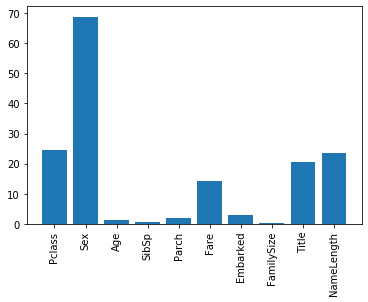

In [18]:
from sklearn.feature_selection import SelectKBest, f_classif    # SelectKBest就是自动评估数据集特征重要性的。原理是为特征加噪声，如果模型准确度变化不大就认为该特征没用。


predictors = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title', 'NameLength']   # 候选特征
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic['Survived'])   # 将候选特征和label标签喂给selector
scores = -np.log10(selector.pvalues_)
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()   # 柱状图越高则特征重要性越高，对于没用特征我们可以从随机森林中剔除。